In [1]:
'''The plan is to simulate stellar mass following the well-known IMF to obtain a random star
out of 10.000 generated or take them all and test them with a selected randomly pair of (M, P) 
and compute the eclipsing time and probabilities many times to obtain the final dependence 
of number of transits with stellar mass.'''

#Standard python packages

from astropy import constants as c
from math import factorial as fac
import matplotlib.pyplot as plt
import numpy as np
import random
import IMF_Generator

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')
%matplotlib inline

In [2]:
'''Stellar Mass Distribution
Assuming stellar mass follows a Salpeter 1955 IMF with slope = -2.35
Stellar mass from 0.1 to 10 solar masses'''

slopes   = [2.35]                        #Inside the script is already negative
masslims = [0.1, 10]                     #Mass limits
myimf    = IMF_Generator.MultiPartPowerLaw(np.array(slopes), np.array(masslims))
m        = np.linspace(masslims[0],masslims[-1], 200)
lnpdf    = myimf.pdf(m)
cdf      = myimf.cdf(m)
N        = 10000                         #Number of stars to generate following the given IMF
ranmass  = myimf.rvs(N)                  #They'll be stored here eventually

In [3]:
'''This computes the period and mass distribution of exoplanets taking into account
that there exist a weak correlation between these parameters. Therefore, the distributions
are obtained using a beta and gamma distribution functions as mentioned in Ing-Guey Jian et al, 2007.'''

M = []                                           #Planet Mass array
P = []                                           #Planet Period array

k = 0
while (k < N):                                   #It generates 10000 planet (M, P) pairs
                                                 #0.008 < M < 26.7 and 0.8079 < P < 6776.1        
    Alpha_m = random.gammavariate(0.5779, 1.0)
    Beta_m  = random.gammavariate(5.5115, 1.0)
    Alpha_p = random.gammavariate(0.2952, 1.0)
    Beta_p  = random.gammavariate(3.4484, 1.0)
    Delta_1 = random.gammavariate(0.0745, 1.0)
    Delta_2 = random.gammavariate(0.3961, 1.0)
    
    M1 = 155.5*(Alpha_m + Delta_1) / (Alpha_m + Delta_1 + Beta_m + Delta_2)
    P1 = 11650.0*(Alpha_p + Delta_1) / (Alpha_p + Delta_1 + Beta_p + Delta_2)
    
    if (M1 > 0.008 and M1 < 26.7) and (P1 > 0.8079 and P1 < 6776.1):
        
        M.append(M1)
        P.append(P1)
        
        k = k + 1

In [4]:
'''Functions and definitions used along the distributions'''

G         = 2.959e-4           # AU^3 / Msun day^2
Masses_CF = 9.5458e-4          #From jupiter mass to solar mass

def MajorAxis(M, m, P):
    
    #M and m in solar mass, P in days = Major axis in AU
    return (G * (M + m) / (4.0*np.pi**2))**(1.0/3.0) * P**(2.0/3.0)

def Eclipsing_Time(M, m, P, epsilon):
    return P * (epsilon / np.pi) * (m / (2.0*M))**(1.0/3.0)

def ocurrence(a, m, M, R, e, epsilon):
    #a in AU, m and M in solar mass, R in AU
    
    RH = epsilon * ( a*(1 - e)*(m / (3.0*M) )**(1.0/3.0) )
    #return R/a              #Point-planet
    return (RH + R) / a      #Hill sphere radius

def Real_prob(Gaia_lifetime, Eclising_duration, Trials):
    return 1.0 - ( (Gaia_lifetime - Eclising_duration) / Gaia_lifetime )**Trials

def Prob_total(p1, p2, p3, p4):
    return np.array(p1*p2*p3*p4)

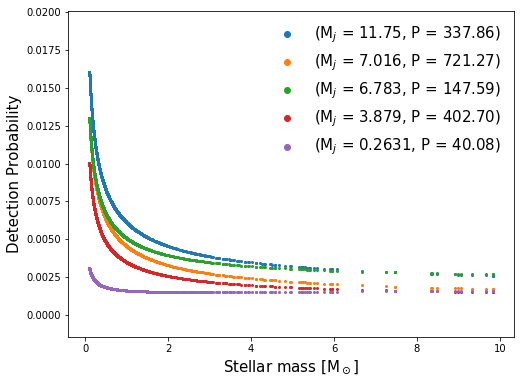

In [7]:
Star_mass     = np.sort(ranmass)           #Solar Masses

Mass_period = np.array([M, P])             #In Mj and days
#Mass_period = Mass_period[::, Mass_period[0,].argsort()[::-1]] #Sorting by mass


Counter = np.linspace(0, N, N + 1)         #It creates the 10000 counters
Planet_mass   = []                         #Planet mass will be stored here (M_sun)
Planet_period = []                         #Planet period will be stored here (days)

for i in range(5):                                                         #Creates 5 pairs
    
    Random_position = random.choice(Counter)                               #Random position is picked-up
    #print(Mass_period_tuple[0:, int(Random_position)])
    Planet_mass.append(Mass_period[0:, int(Random_position)][0]*Masses_CF) #Picks a mass (M_sun)
    Planet_period.append(Mass_period[0:, int(Random_position)][1])         #Picks a period (days)    

#print(Planet_mass, Planet_period)   

Re_order = np.array([Planet_mass, Planet_period])    
Re_order = Re_order[::, Re_order[0,].argsort()[::-1]]   

Planet_mass   = Re_order[0:,][0]                         #Planet mass will be stored here (M_sun)
Planet_period = Re_order[0:,][1]                         #Planet period will be stored here (days)
#print(Planet_mass, Planet_period)
plt.figure(figsize = (8,6))

for j in range(5):
    
    Planet_maxis  = np.array(MajorAxis(Star_mass, Planet_mass[j], Planet_period[j]))
    R_sun         = 0.00465                              #In AU
    R_star        = np.array(R_sun * (Star_mass)**0.8)   #Following a Main Sequence Mass-to-Radius relation

    Prob   = ocurrence(Planet_maxis, Planet_mass[j], Star_mass, R_star, e = 0.0, epsilon = 0.3)
    E_time = Eclipsing_Time(Star_mass, Planet_mass[j], Planet_period[j], epsilon = 0.3)

    P1     = 0.17                                   #Cassen et al. 2012 for (0.3-10M_J) within (0.5-10AU)
    P2     = 1.00                                   #Best case
    P3     = Prob                                   #Planet_mass = 10M_J, Planet_period = 5yr, epsilon = 0.3
    P4     = Real_prob(Planet_period[j], E_time, 70.0) #Gaia NO-observation probability
    
    
    plt.scatter(Star_mass, Prob_total(P1, P2, P3, P4), s = 4, label = r'(M$_j$ = %.4g, P = %.2f)'%(Planet_mass[j]/Masses_CF, Planet_period[j]))
    
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 15)
plt.ylabel('Detection Probability', size = 15)
plt.legend(frameon = False, loc = 'best', prop = {'size': 15}, markerscale = 3);

plt.savefig('StellarMass_Detections.png')